In [ ]:
# Cell 1 — Install packages & GPU check
!pip install -q tensorflow==2.12.0 albumentations==1.3.0 opencv-python matplotlib seaborn scikit-learn gdown tqdm

import tensorflow as tf, os, random, numpy as np
print('TensorFlow', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

# determinism (best-effort)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
TensorFlow 2.19.0
GPUs: []


In [ ]:
# Cell 2 — Mount Drive & set paths
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_CACHE_DIR = '/content/drive/MyDrive/Underwater_Cache'
os.makedirs(BASE_CACHE_DIR, exist_ok=True)

TRAIN_IMAGES_DIR = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/train/images'
TRAIN_LABELS_DIR = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/train/labels'
VALID_IMAGES_DIR = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/valid/images'
VALID_LABELS_DIR = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/valid/labels'
TEST_IMAGES_DIR  = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/test/images'
TEST_LABELS_DIR  = '/content/drive/My Drive/Tahmeed Thesis/Dataset/underwater_plastics/test/labels'

TRAIN_INDEX_PKL = os.path.join(BASE_CACHE_DIR, 'train_index.pkl')
VAL_INDEX_PKL   = os.path.join(BASE_CACHE_DIR, 'val_index.pkl')
TEST_INDEX_PKL  = os.path.join(BASE_CACHE_DIR, 'test_index.pkl')

CROPS_DIR = os.path.join(BASE_CACHE_DIR, 'crops')  # will contain split/class subfolders if extracted

MODELS_DIR = '/content/drive/My Drive/Tahmeed Thesis/models'
os.makedirs(MODELS_DIR, exist_ok=True)

CLASS_NAMES = ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove',
               'metal', 'misc', 'net', 'pbag', 'pbottle', 'plastic',
               'rod', 'sunglasses', 'tire']
NUM_CLASSES = len(CLASS_NAMES)
print('NUM_CLASSES =', NUM_CLASSES)

Mounted at /content/drive
NUM_CLASSES = 15


In [ ]:
# Cell 3 — Build/load index (multiprocessing) and cache to pickle
import os, pickle, cv2
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def parse_yolo_to_boxes(args):
    img_path, label_path = args
    out = []
    try:
        img = cv2.imread(img_path)
        if img is None:
            return out
        h, w = img.shape[:2]
        if not os.path.exists(label_path):
            return out
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                x_c, y_c, bw, bh = map(float, parts[1:5])
                x_c *= w; y_c *= h; bw *= w; bh *= h
                x1 = int(max(0, x_c - bw/2)); y1 = int(max(0, y_c - bh/2))
                x2 = int(min(w-1, x_c + bw/2)); y2 = int(min(h-1, y_c + bh/2))
                if x2 > x1 and y2 > y1:
                    out.append((img_path, cls, x1, y1, x2, y2))
    except Exception as e:
        return out
    return out

def build_index_mp(images_dir, labels_dir, out_pkl, force_rebuild=False):
    if os.path.exists(out_pkl) and not force_rebuild:
        print(f'Loading cached index from {out_pkl}')
        with open(out_pkl, 'rb') as f:
            return pickle.load(f)
    imgs = [fn for fn in os.listdir(images_dir) if fn.lower().endswith(('.jpg','.jpeg','.png'))]
    args = [(os.path.join(images_dir, fn), os.path.join(labels_dir, os.path.splitext(fn)[0]+'.txt')) for fn in imgs]
    print('Building index with multiprocessing (this can take a few minutes)...')
    index = []
    n_workers = max(1, min(8, cpu_count()-1))
    with Pool(n_workers) as p:
        for boxes in tqdm(p.imap_unordered(parse_yolo_to_boxes, args), total=len(args)):
            if boxes:
                index.extend(boxes)
    print('Found', len(index), 'object-crops')
    with open(out_pkl, 'wb') as f:
        pickle.dump(index, f)
    print('Saved index to', out_pkl)
    return index

train_index = build_index_mp(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, TRAIN_INDEX_PKL)
val_index   = build_index_mp(VALID_IMAGES_DIR, VALID_LABELS_DIR, VAL_INDEX_PKL)
test_index  = build_index_mp(TEST_IMAGES_DIR, TEST_LABELS_DIR, TEST_INDEX_PKL)

print('Counts -> train:', len(train_index), 'val:', len(val_index), 'test:', len(test_index))

Loading cached index from /content/drive/MyDrive/Underwater_Cache/train_index.pkl
Loading cached index from /content/drive/MyDrive/Underwater_Cache/val_index.pkl
Loading cached index from /content/drive/MyDrive/Underwater_Cache/test_index.pkl
Counts -> train: 8802 val: 1891 test: 966


In [ ]:
# Cell 4 — One-time crop extraction
EXTRACT_CROPS = False  # set True only once to write crops into split/class subfolders

import cv2, os
from tqdm import tqdm

def save_crop(item, split_name):
    img_path, cls, x1, y1, x2, y2 = item
    img = cv2.imread(img_path)
    if img is None:
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        crop = cv2.resize(img, (224, 224))
    split_cls_dir = os.path.join(CROPS_DIR, split_name, str(cls))
    os.makedirs(split_cls_dir, exist_ok=True)
    basename = os.path.splitext(os.path.basename(img_path))[0]
    out_name = f"{basename}_{x1}_{y1}_{x2}_{y2}_cls{cls}.jpg"
    out_path = os.path.join(split_cls_dir, out_name)
    cv2.imwrite(out_path, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

if EXTRACT_CROPS:
    print("Saving TRAIN crops...")
    for it in tqdm(train_index):
        save_crop(it, "train")
    print("Saving VAL crops...")
    for it in tqdm(val_index):
        save_crop(it, "val")
    print("Saving TEST crops...")
    for it in tqdm(test_index):
        save_crop(it, "test")
    print("All crops saved inside:", CROPS_DIR)
else:
    print("EXTRACT_CROPS is False — skipping. Set True only once to cache crops in split/class subfolders.")

EXTRACT_CROPS is False — skipping. Set True only once to cache crops in split/class subfolders.


In [ ]:
# Cell 5 — Keras Sequence (supports cached crops) with moderate MixUp/CutMix
import numpy as np, glob, random
import albumentations as A
from tensorflow.keras.utils import Sequence
import cv2, tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 64
USE_CACHED_CROPS = os.path.exists(CROPS_DIR) and any(os.scandir(CROPS_DIR))

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomBrightnessContrast(p=0.6),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.12),
    A.Rotate(limit=12, p=0.2),
    A.CLAHE(p=0.2),
    A.RandomGamma(p=0.2),
    A.Normalize()
])
val_transform = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize()])

def mixup_batch(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idxs = np.random.permutation(x.shape[0])
    x2 = x[idxs]; y2 = y[idxs]
    x = lam * x + (1 - lam) * x2
    y = lam * y + (1 - lam) * y2
    return x, y

def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def cutmix_batch(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    idxs = np.random.permutation(x.shape[0])
    x2 = x[idxs]; y2 = y[idxs]
    for i in range(x.shape[0]):
        W = x.shape[2]; H = x.shape[1]
        x1, y1, x2b, y2b = rand_bbox(W, H, lam)
        x[i, y1:y2b, x1:x2b, :] = x2[i, y1:y2b, x1:x2b, :]
        lam_adj = 1 - ((x2b - x1) * (y2b - y1) / (W * H) + 1e-8)
        y[i] = lam_adj * y[i] + (1 - lam_adj) * y2[i]
    return x, y

class ObjectCropSequence(Sequence):
    def __init__(self, index_list=None, crops_root=None, split=None, batch_size=BATCH_SIZE, transform=None, shuffle=True, mixup_prob=0.25, cutmix_prob=0.08):
        self.use_crops = USE_CACHED_CROPS and (crops_root is not None)
        if self.use_crops:
            self.crops = []
            split_dir = os.path.join(crops_root, split)
            if os.path.exists(split_dir):
                for class_id in os.listdir(split_dir):
                    class_dir = os.path.join(split_dir, class_id)
                    if not os.path.isdir(class_dir): continue
                    for p in glob.glob(os.path.join(class_dir, '*.jpg')):
                        try:
                            cid = int(class_id)
                            self.crops.append((p, cid))
                        except:
                            continue
            self.length = len(self.crops)
        else:
            self.index_list = index_list
            self.length = len(index_list)
        self.batch_size = batch_size
        self.transform = transform
        self.shuffle = shuffle
        self.mixup_prob = mixup_prob
        self.cutmix_prob = cutmix_prob
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.length / self.batch_size))

    def __getitem__(self, idx):
        images, labels = [], []
        if self.use_crops:
            batch = self.crops[idx*self.batch_size:(idx+1)*self.batch_size]
            for p, cls in batch:
                img = cv2.imread(p); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if self.transform: img = self.transform(image=img)['image']
                images.append(img.astype(np.float32)); labels.append(cls)
        else:
            batch = self.index_list[idx*self.batch_size:(idx+1)*self.batch_size]
            for img_path, cls, x1,y1,x2,y2 in batch:
                img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                crop = img[y1:y2, x1:x2]
                if crop.size == 0:
                    crop = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                if self.transform: crop = self.transform(image=crop)['image']
                images.append(crop.astype(np.float32)); labels.append(cls)
        images = np.array(images)
        labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES).astype(np.float32)

        if images.shape[0] > 1:
            r = np.random.rand()
            if r < self.cutmix_prob:
                images, labels = cutmix_batch(images, labels, alpha=1.0)
            elif r < self.cutmix_prob + self.mixup_prob:
                images, labels = mixup_batch(images, labels, alpha=0.2)
        return images, labels

    def on_epoch_end(self):
        if self.use_crops:
            if self.shuffle: random.shuffle(self.crops)
        else:
            if self.shuffle: random.shuffle(self.index_list)

# Create sequences
if USE_CACHED_CROPS:
    train_seq = ObjectCropSequence(crops_root=CROPS_DIR, split='train', batch_size=BATCH_SIZE, transform=train_transform, shuffle=True, mixup_prob=0.25, cutmix_prob=0.08)
    val_seq   = ObjectCropSequence(crops_root=CROPS_DIR, split='val',   batch_size=BATCH_SIZE, transform=val_transform,   shuffle=False, mixup_prob=0.0,  cutmix_prob=0.0)
    test_seq  = ObjectCropSequence(crops_root=CROPS_DIR, split='test',  batch_size=BATCH_SIZE, transform=val_transform,   shuffle=False, mixup_prob=0.0,  cutmix_prob=0.0)
else:
    train_seq = ObjectCropSequence(index_list=train_index, batch_size=BATCH_SIZE, transform=train_transform, shuffle=True, mixup_prob=0.25, cutmix_prob=0.08)
    val_seq   = ObjectCropSequence(index_list=val_index,   batch_size=BATCH_SIZE, transform=val_transform,   shuffle=False, mixup_prob=0.0,  cutmix_prob=0.0)
    test_seq  = ObjectCropSequence(index_list=test_index,  batch_size=BATCH_SIZE, transform=val_transform,   shuffle=False, mixup_prob=0.0,  cutmix_prob=0.0)

print('USE_CACHED_CROPS =', USE_CACHED_CROPS)
print('train batches:', len(train_seq), 'val batches:', len(val_seq), 'test batches:', len(test_seq))

USE_CACHED_CROPS = True
train batches: 138 val batches: 30 test batches: 16


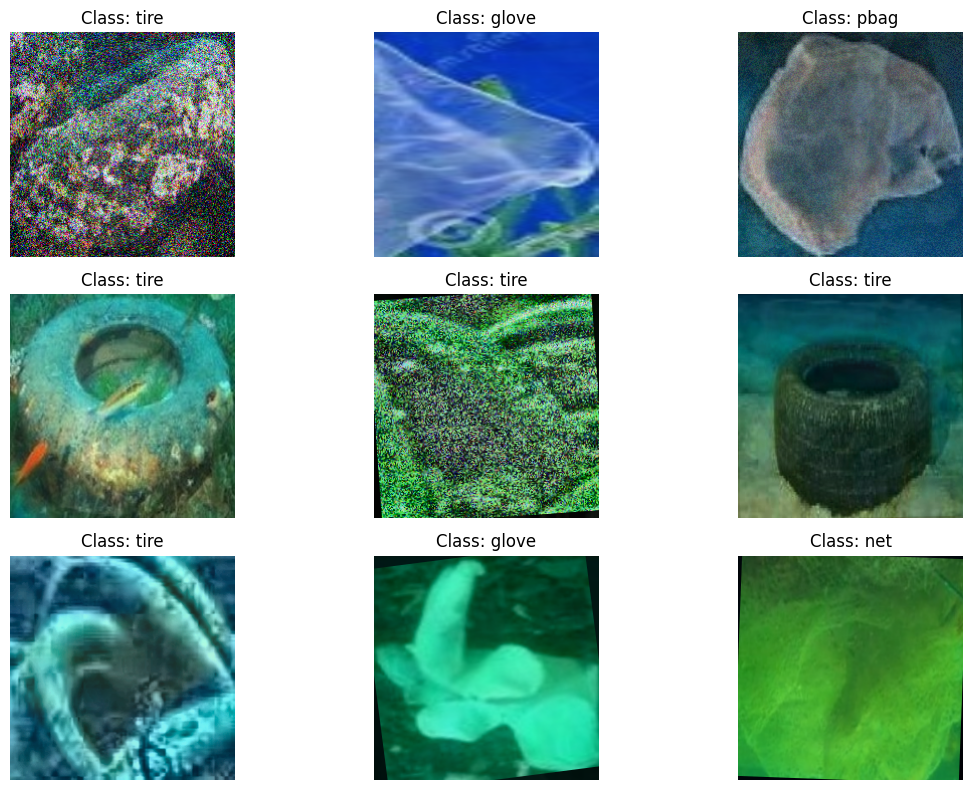

In [ ]:
# Cell 5.1 — Visualize sample data
import matplotlib.pyplot as plt
import numpy as np

def denormalize_img(img):
    mean = np.array([0.485, 0.456, 0.406]) # for common ImageNet normalization
    std = np.array([0.229, 0.224, 0.225])
    img_denorm = img * std + mean
    return np.clip(img_denorm * 255, 0, 255).astype(np.uint8)

# Get a batch from the training sequence
X_batch, y_batch = train_seq[np.random.randint(len(train_seq))]

plt.figure(figsize=(12, 8))
for i in range(min(9, X_batch.shape[0])):
    plt.subplot(3, 3, i + 1)
    # Denormalize image for proper display if normalization was applied
    img_display = denormalize_img(X_batch[i])
    plt.imshow(img_display)

    true_label_idx = np.argmax(y_batch[i])
    plt.title(f'Class: {CLASS_NAMES[true_label_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'sample_data_visualization.png'))
plt.show()

In [ ]:
# Cell 6 — Focal loss, slight label smoothing, compute class weights
import numpy as np, tensorflow as tf
from collections import Counter

def focal_loss(gamma=2.0, alpha=0.25):
    def fl(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        loss = weights * ce
        return tf.reduce_sum(loss, axis=1)
    return fl

LABEL_SMOOTHING = 0.03

counts = Counter([cls for (_, cls, *_ ) in train_index])
freqs = np.array([counts.get(i,0) for i in range(NUM_CLASSES)], dtype=np.float32)
total = freqs.sum()
class_weights = {}
for i,c in enumerate(freqs):
    class_weights[i] = float(total / (NUM_CLASSES * c)) if c>0 else 1.0
print('Computed class_weights (use in fit):', class_weights)

Computed class_weights (use in fit): {0: 0.4060899615287781, 1: 4.732257843017578, 2: 2.1895523071289062, 3: 4.283211708068848, 4: 1.730973482131958, 5: 0.5006825923919678, 6: 10.478571891784668, 7: 3.3919074535369873, 8: 1.105084776878357, 9: 0.5170044302940369, 10: 0.6296137571334839, 11: 3.3340909481048584, 12: 22.569231033325195, 13: 41.91428756713867, 14: 0.258047491312027}


In [ ]:
# Cell 7 — Build multi-scale ULENet + EfficientNetB4 multi-scale fusion (CNN-only)
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import tensorflow as tf

def cbam_block(x, reduction=8):
    # Channel attention
    ch = x.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)
    dense1 = layers.Dense(ch//reduction, activation='relu')
    dense2 = layers.Dense(ch, activation='sigmoid')
    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))
    ch_att = layers.Add()([avg_out, max_out])
    ch_att = layers.Reshape((1,1,ch))(ch_att)
    x = layers.Multiply()([x, ch_att])
    # Spatial attention
    avg_pool_sp = tf.keras.ops.mean(x, axis=-1, keepdims=True)
    max_pool_sp = tf.keras.ops.max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool_sp, max_pool_sp])
    sp = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, sp])
    return x

def ulenet_multiscale(input_tensor):
    # returns list of feature maps at multiple scales
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    f1 = x  # scale1 (H/1)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    f2 = x  # scale2 (H/2)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    f3 = x  # scale3 (H/4)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    f4 = x  # scale4 (H/8)
    # return multi-scale features
    return [f1, f2, f3, f4]

# Input
IMG_SIZE = 224
input_tensor = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# EfficientNetB4 backbone and find multi-scale layers by name patterns
x_pre = layers.Lambda(efficientnet_preprocess, name='preprocess_efficientnet')(input_tensor)
base_eff = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=x_pre)

# heuristics: find layers that contain 'block2', 'block4', 'block6' (best-effort)
def find_layer_by_substr(model, substr_list):
    chosen = []
    for substr in substr_list:
        found = None
        for layer in model.layers:
            if substr in layer.name:
                found = layer.name
        if found:
            chosen.append(found)
    return chosen

chosen_names = find_layer_by_substr(base_eff, ['block2', 'block4', 'block6'])
# fallback: if not found, use a few intermediate layers by index
if len(chosen_names) < 3:
    # pick evenly spaced internal layers
    L = len(base_eff.layers)
    chosen_names = [base_eff.layers[int(L*0.2)].name, base_eff.layers[int(L*0.5)].name, base_eff.layers[int(L*0.8)].name]

# collect outputs
eff_outputs = [base_eff.get_layer(name).output for name in chosen_names]  # e.g. [block2_out, block4_out, block6_out]
eff_outputs.append(base_eff.output)  # final feature map

# ULENet multi-scale features
ulenet_feats = ulenet_multiscale(input_tensor)  # [f1,f2,f3,f4]

# process eff multi-scale features: project to common channel and pool
proj_feats = []
for feat in eff_outputs:
    p = layers.Conv2D(128, 1, padding='same', activation='relu')(feat)
    p = layers.BatchNormalization()(p)
    # global pooling spatially (we will keep both pooled and small spatial map)
    p_pool = layers.GlobalAveragePooling2D()(p)
    proj_feats.append(p_pool)

# process ulenet multi-scale features similarly
for feat in ulenet_feats:
    p = layers.Conv2D(128, 1, padding='same', activation='relu')(feat)
    p = layers.BatchNormalization()(p)
    p_pool = layers.GlobalAveragePooling2D()(p)
    proj_feats.append(p_pool)

# concat all pooled multi-scale vectors
fusion_vec = layers.Concatenate()(proj_feats)  # shape (batch, 128 * (len(eff_outputs)+len(ulenet_feats)))
fusion_vec = layers.Dense(1024, activation='gelu')(fusion_vec)
fusion_vec = layers.BatchNormalization()(fusion_vec)
fusion_vec = layers.Dropout(0.5)(fusion_vec)

# final classification head
x = layers.Dense(512, activation='gelu')(fusion_vec)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output, name='MultiScale_EffB4_ULENet_CNN_Hybrid')
model.summary()

Model: "MultiScale_EffB4_ULENet_CNN_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_efficie… │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ preprocess_effic… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 20,809,647 (79.38 MB)

 Trainable params: 20,677,400 (78.88 MB)

 Non-trainable params: 132,247 (516.59 KB)

In [ ]:
# Cell 8 — Compile model and focal loss
import tensorflow as tf
try:
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    print('Using AdamW (experimental)')
except Exception as e:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    print('AdamW unavailable; using Adam')

loss_fn = focal_loss(gamma=2.0, alpha=0.25)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

AdamW unavailable; using Adam


In [ ]:
# Cell 9 — Callbacks: checkpoint, early stopping, LR reduce, Unfreeze callback with assign
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf, os

checkpoint_path = os.path.join(MODELS_DIR, 'multiscale_effb4_hybrid_best.h5')
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

class UnfreezeAndFineTune(Callback):
    def __init__(self, base_model, unfreeze_after_epoch=3, num_unfreeze_layers=120, new_lr=5e-6):
        super().__init__()
        self.base_model = base_model
        self.unfreeze_after_epoch = unfreeze_after_epoch
        self.num_unfreeze_layers = num_unfreeze_layers
        self.new_lr = new_lr
        self.unfrozen = False

    def on_epoch_end(self, epoch, logs=None):
        if not self.unfrozen and epoch + 1 >= self.unfreeze_after_epoch:
            print(f'Unfreezing last {self.num_unfreeze_layers} layers of base model at epoch {epoch+1}')
            total_layers = len(self.base_model.layers)
            for layer in self.base_model.layers[-self.num_unfreeze_layers:]:
                layer.trainable = True
            # Assign new LR using assign() when possible
            try:
                self.model.optimizer.learning_rate.assign(self.new_lr)
                print('Assigned new LR via assign:', self.new_lr)
            except Exception as e:
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.new_lr)
                print('Fallback set_value LR:', self.new_lr)
            self.unfrozen = True

# create and append
unfreeze_cb = UnfreezeAndFineTune(base_model=base_eff, unfreeze_after_epoch=3, num_unfreeze_layers=120, new_lr=5e-6)
callbacks.append(unfreeze_cb)

In [ ]:
# Cell 10 — Train model
EPOCHS = 80
print('Starting training: epochs=', EPOCHS)
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)
model.save(os.path.join(MODELS_DIR, 'multiscale_effb4_hybrid_final.h5'))

Starting training: epochs= 80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.1186 - loss: 0.8791 
Epoch 1: val_loss improved from inf to 0.62111, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 3280s 22s/step - accuracy: 0.1189 - loss: 0.8781 - val_accuracy: 0.0164 - val_loss: 0.6211 - learning_rate: 1.0000e-04
Epoch 2/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2645 - loss: 0.5623
Epoch 2: val_loss improved from 0.62111 to 0.35002, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.2646 - loss: 0.5622 - val_accuracy: 0.4659 - val_loss: 0.3500 - learning_rate: 1.0000e-04
Epoch 3/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3759 - loss: 0.4403
Epoch 3: val_loss improved from 0.35002 to 0.19208, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


Unfreezing last 120 layers of base model at epoch 3
Assigned new LR via assign: 5e-06
138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.3760 - loss: 0.4403 - val_accuracy: 0.6626 - val_loss: 0.1921 - learning_rate: 1.0000e-04
Epoch 4/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4455 - loss: 0.4216
Epoch 4: val_loss improved from 0.19208 to 0.17676, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4455 - loss: 0.4214 - val_accuracy: 0.7017 - val_loss: 0.1768 - learning_rate: 5.0000e-06
Epoch 5/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4506 - loss: 0.3710
Epoch 5: val_loss improved from 0.17676 to 0.16198, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4506 - loss: 0.3710 - val_accuracy: 0.7255 - val_loss: 0.1620 - learning_rate: 5.0000e-06
Epoch 6/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4672 - loss: 0.3671
Epoch 6: val_loss did not improve from 0.16198
138/138 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4672 - loss: 0.3673 - val_accuracy: 0.7203 - val_loss: 0.1627 - learning_rate: 5.0000e-06
Epoch 7/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4530 - loss: 0.3628
Epoch 7: val_loss improved from 0.16198 to 0.16081, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4531 - loss: 0.3627 - val_accuracy: 0.7287 - val_loss: 0.1608 - learning_rate: 5.0000e-06
Epoch 8/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4723 - loss: 0.3930
Epoch 8: val_loss improved from 0.16081 to 0.15733, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4723 - loss: 0.3929 - val_accuracy: 0.7345 - val_loss: 0.1573 - learning_rate: 5.0000e-06
Epoch 9/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4866 - loss: 0.3766
Epoch 9: val_loss improved from 0.15733 to 0.15496, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4866 - loss: 0.3766 - val_accuracy: 0.7372 - val_loss: 0.1550 - learning_rate: 5.0000e-06
Epoch 10/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4909 - loss: 0.3384
Epoch 10: val_loss improved from 0.15496 to 0.15176, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4909 - loss: 0.3384 - val_accuracy: 0.7403 - val_loss: 0.1518 - learning_rate: 5.0000e-06
Epoch 11/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4800 - loss: 0.3467
Epoch 11: val_loss improved from 0.15176 to 0.14891, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.4801 - loss: 0.3467 - val_accuracy: 0.7467 - val_loss: 0.1489 - learning_rate: 5.0000e-06
Epoch 12/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5067 - loss: 0.3458
Epoch 12: val_loss improved from 0.14891 to 0.14476, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5067 - loss: 0.3458 - val_accuracy: 0.7530 - val_loss: 0.1448 - learning_rate: 5.0000e-06
Epoch 13/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5052 - loss: 0.3831
Epoch 13: val_loss improved from 0.14476 to 0.14045, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5052 - loss: 0.3829 - val_accuracy: 0.7589 - val_loss: 0.1405 - learning_rate: 5.0000e-06
Epoch 14/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5046 - loss: 0.3292
Epoch 14: val_loss improved from 0.14045 to 0.13950, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5046 - loss: 0.3293 - val_accuracy: 0.7663 - val_loss: 0.1395 - learning_rate: 5.0000e-06
Epoch 15/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4981 - loss: 0.3399
Epoch 15: val_loss improved from 0.13950 to 0.13781, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.4981 - loss: 0.3400 - val_accuracy: 0.7673 - val_loss: 0.1378 - learning_rate: 5.0000e-06
Epoch 16/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5323 - loss: 0.3152
Epoch 16: val_loss improved from 0.13781 to 0.13518, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5323 - loss: 0.3151 - val_accuracy: 0.7710 - val_loss: 0.1352 - learning_rate: 5.0000e-06
Epoch 17/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5187 - loss: 0.3493
Epoch 17: val_loss improved from 0.13518 to 0.13295, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5188 - loss: 0.3493 - val_accuracy: 0.7689 - val_loss: 0.1329 - learning_rate: 5.0000e-06
Epoch 18/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5330 - loss: 0.3128
Epoch 18: val_loss improved from 0.13295 to 0.13131, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5329 - loss: 0.3129 - val_accuracy: 0.7715 - val_loss: 0.1313 - learning_rate: 5.0000e-06
Epoch 19/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5339 - loss: 0.3009
Epoch 19: val_loss improved from 0.13131 to 0.12723, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5340 - loss: 0.3009 - val_accuracy: 0.7800 - val_loss: 0.1272 - learning_rate: 5.0000e-06
Epoch 20/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5477 - loss: 0.2925
Epoch 20: val_loss improved from 0.12723 to 0.12520, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5477 - loss: 0.2924 - val_accuracy: 0.7811 - val_loss: 0.1252 - learning_rate: 5.0000e-06
Epoch 21/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5462 - loss: 0.2982
Epoch 21: val_loss improved from 0.12520 to 0.12280, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5462 - loss: 0.2982 - val_accuracy: 0.7853 - val_loss: 0.1228 - learning_rate: 5.0000e-06
Epoch 22/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5456 - loss: 0.2983
Epoch 22: val_loss improved from 0.12280 to 0.11967, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5457 - loss: 0.2983 - val_accuracy: 0.7911 - val_loss: 0.1197 - learning_rate: 5.0000e-06
Epoch 23/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5718 - loss: 0.2695
Epoch 23: val_loss improved from 0.11967 to 0.11872, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5717 - loss: 0.2696 - val_accuracy: 0.7927 - val_loss: 0.1187 - learning_rate: 5.0000e-06
Epoch 24/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5597 - loss: 0.3100
Epoch 24: val_loss improved from 0.11872 to 0.11652, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5598 - loss: 0.3099 - val_accuracy: 0.7980 - val_loss: 0.1165 - learning_rate: 5.0000e-06
Epoch 25/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5623 - loss: 0.2888
Epoch 25: val_loss improved from 0.11652 to 0.11490, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5623 - loss: 0.2888 - val_accuracy: 0.8001 - val_loss: 0.1149 - learning_rate: 5.0000e-06
Epoch 26/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5707 - loss: 0.2730
Epoch 26: val_loss improved from 0.11490 to 0.11327, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5707 - loss: 0.2730 - val_accuracy: 0.8038 - val_loss: 0.1133 - learning_rate: 5.0000e-06
Epoch 27/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5834 - loss: 0.2900
Epoch 27: val_loss improved from 0.11327 to 0.10958, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5834 - loss: 0.2899 - val_accuracy: 0.8096 - val_loss: 0.1096 - learning_rate: 5.0000e-06
Epoch 28/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5904 - loss: 0.2829
Epoch 28: val_loss improved from 0.10958 to 0.10854, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5903 - loss: 0.2829 - val_accuracy: 0.8102 - val_loss: 0.1085 - learning_rate: 5.0000e-06
Epoch 29/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6017 - loss: 0.2573
Epoch 29: val_loss improved from 0.10854 to 0.10755, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6017 - loss: 0.2573 - val_accuracy: 0.8096 - val_loss: 0.1075 - learning_rate: 5.0000e-06
Epoch 30/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5868 - loss: 0.2978
Epoch 30: val_loss improved from 0.10755 to 0.10570, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5868 - loss: 0.2977 - val_accuracy: 0.8149 - val_loss: 0.1057 - learning_rate: 5.0000e-06
Epoch 31/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5893 - loss: 0.2809
Epoch 31: val_loss improved from 0.10570 to 0.10379, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.5893 - loss: 0.2809 - val_accuracy: 0.8170 - val_loss: 0.1038 - learning_rate: 5.0000e-06
Epoch 32/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6147 - loss: 0.2491
Epoch 32: val_loss improved from 0.10379 to 0.10152, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6146 - loss: 0.2492 - val_accuracy: 0.8234 - val_loss: 0.1015 - learning_rate: 5.0000e-06
Epoch 33/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6057 - loss: 0.2557
Epoch 33: val_loss improved from 0.10152 to 0.10042, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6058 - loss: 0.2557 - val_accuracy: 0.8265 - val_loss: 0.1004 - learning_rate: 5.0000e-06
Epoch 34/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6160 - loss: 0.2504
Epoch 34: val_loss improved from 0.10042 to 0.09897, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6160 - loss: 0.2505 - val_accuracy: 0.8292 - val_loss: 0.0990 - learning_rate: 5.0000e-06
Epoch 35/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5927 - loss: 0.3328
Epoch 35: val_loss improved from 0.09897 to 0.09835, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5928 - loss: 0.3325 - val_accuracy: 0.8281 - val_loss: 0.0984 - learning_rate: 5.0000e-06
Epoch 36/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6010 - loss: 0.2796
Epoch 36: val_loss improved from 0.09835 to 0.09797, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6012 - loss: 0.2794 - val_accuracy: 0.8276 - val_loss: 0.0980 - learning_rate: 5.0000e-06
Epoch 37/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5999 - loss: 0.2553
Epoch 37: val_loss improved from 0.09797 to 0.09621, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6000 - loss: 0.2553 - val_accuracy: 0.8302 - val_loss: 0.0962 - learning_rate: 5.0000e-06
Epoch 38/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6152 - loss: 0.2661
Epoch 38: val_loss improved from 0.09621 to 0.09440, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6153 - loss: 0.2659 - val_accuracy: 0.8371 - val_loss: 0.0944 - learning_rate: 5.0000e-06
Epoch 39/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6339 - loss: 0.2246
Epoch 39: val_loss improved from 0.09440 to 0.09334, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6339 - loss: 0.2248 - val_accuracy: 0.8392 - val_loss: 0.0933 - learning_rate: 5.0000e-06
Epoch 40/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6220 - loss: 0.2684
Epoch 40: val_loss improved from 0.09334 to 0.09093, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6220 - loss: 0.2683 - val_accuracy: 0.8466 - val_loss: 0.0909 - learning_rate: 5.0000e-06
Epoch 41/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6187 - loss: 0.2558
Epoch 41: val_loss improved from 0.09093 to 0.08915, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6187 - loss: 0.2558 - val_accuracy: 0.8466 - val_loss: 0.0892 - learning_rate: 5.0000e-06
Epoch 42/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6446 - loss: 0.2229
Epoch 42: val_loss improved from 0.08915 to 0.08854, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6445 - loss: 0.2230 - val_accuracy: 0.8472 - val_loss: 0.0885 - learning_rate: 5.0000e-06
Epoch 43/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6520 - loss: 0.2289
Epoch 43: val_loss improved from 0.08854 to 0.08765, saving model to /content/drive/My Drive/Tahmeed Thesis/models/multiscale_effb4_hybrid_best.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6519 - loss: 0.2289 - val_accuracy: 0.8519 - val_loss: 0.0877 - learning_rate: 5.0000e-06
Epoch 44/80
  8/138 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.6786 - loss: 0.2234

KeyboardInterrupt: 

In [ ]:
val_loss, val_acc = model.evaluate(val_seq)
print(f"Validation Accuracy: {val_acc:.2f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.8947 - loss: 0.0618
Validation Accuracy: 0.85


NameError: name 'history' is not defined

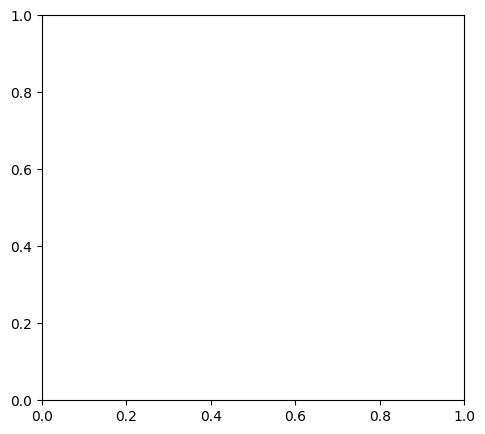

In [ ]:
# Cell 11 — Plot training curves and save
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.title('Loss')

plt.tight_layout(); plt.savefig(os.path.join(MODELS_DIR,'training_curves_advanced.png')); plt.show()

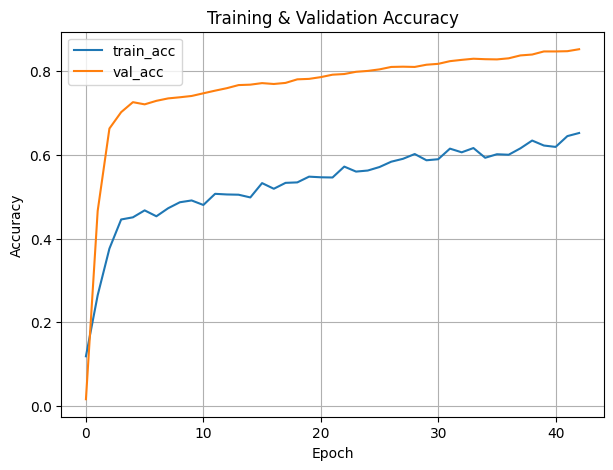

Saved accuracy curve to: /content/drive/My Drive/Tahmeed Thesis/models/training_accuracy_curve.png


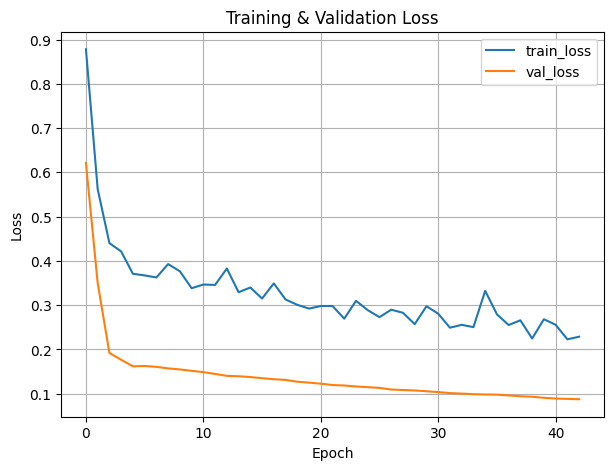

Saved loss curve to: /content/drive/My Drive/Tahmeed Thesis/models/training_loss_curve.png


In [ ]:
# Cell 11 — Plot training curves and save (Manually ploted as I stopped training on 43 epochs)

import matplotlib.pyplot as plt
import numpy as np
import os
acc = [
0.1189,0.2646,0.3760,0.4455,0.4506,0.4672,0.4531,0.4723,0.4866,0.4909,
0.4801,0.5067,0.5052,0.5046,0.4981,0.5323,0.5188,0.5329,0.5340,0.5477,
0.5462,0.5457,0.5717,0.5598,0.5623,0.5707,0.5834,0.5903,0.6017,0.5868,
0.5893,0.6146,0.6058,0.6160,0.5928,0.6012,0.6000,0.6153,0.6339,0.6220,
0.6187,0.6445,0.6519
]

val_acc = [
0.0164,0.4659,0.6626,0.7017,0.7255,0.7203,0.7287,0.7345,0.7372,0.7403,
0.7467,0.7530,0.7589,0.7663,0.7673,0.7710,0.7689,0.7715,0.7800,0.7811,
0.7853,0.7911,0.7927,0.7980,0.8001,0.8038,0.8096,0.8102,0.8096,0.8149,
0.8170,0.8234,0.8265,0.8292,0.8281,0.8276,0.8302,0.8371,0.8392,0.8466,
0.8466,0.8472,0.8519
]

loss = [
0.8781,0.5622,0.4403,0.4214,0.3710,0.3673,0.3627,0.3929,0.3766,0.3384,
0.3467,0.3458,0.3829,0.3293,0.3400,0.3151,0.3493,0.3129,0.3009,0.2924,
0.2982,0.2983,0.2696,0.3099,0.2888,0.2730,0.2899,0.2829,0.2573,0.2977,
0.2809,0.2492,0.2557,0.2505,0.3325,0.2794,0.2553,0.2659,0.2248,0.2683,
0.2558,0.2230,0.2289
]

val_loss = [
0.6211,0.3500,0.1921,0.1768,0.1620,0.1627,0.1608,0.1573,0.1550,0.1518,
0.1489,0.1448,0.1405,0.1395,0.1378,0.1352,0.1329,0.1313,0.1272,0.1252,
0.1228,0.1197,0.1187,0.1165,0.1149,0.1133,0.1096,0.1085,0.1075,0.1057,
0.1038,0.1015,0.1004,0.0990,0.0984,0.0980,0.0962,0.0944,0.0933,0.0909,
0.0892,0.0885,0.0877
]

plt.figure(figsize=(7,5))
plt.plot(acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training & Validation Accuracy')

save_path_acc = os.path.join(MODELS_DIR, 'training_accuracy_curve.png')
plt.savefig(save_path_acc, bbox_inches='tight')
plt.show()

print("Saved accuracy curve to:", save_path_acc)

plt.figure(figsize=(7,5))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training & Validation Loss')

save_path_loss = os.path.join(MODELS_DIR, 'training_loss_curve.png')
plt.savefig(save_path_loss, bbox_inches='tight')
plt.show()

print("Saved loss curve to:", save_path_loss)

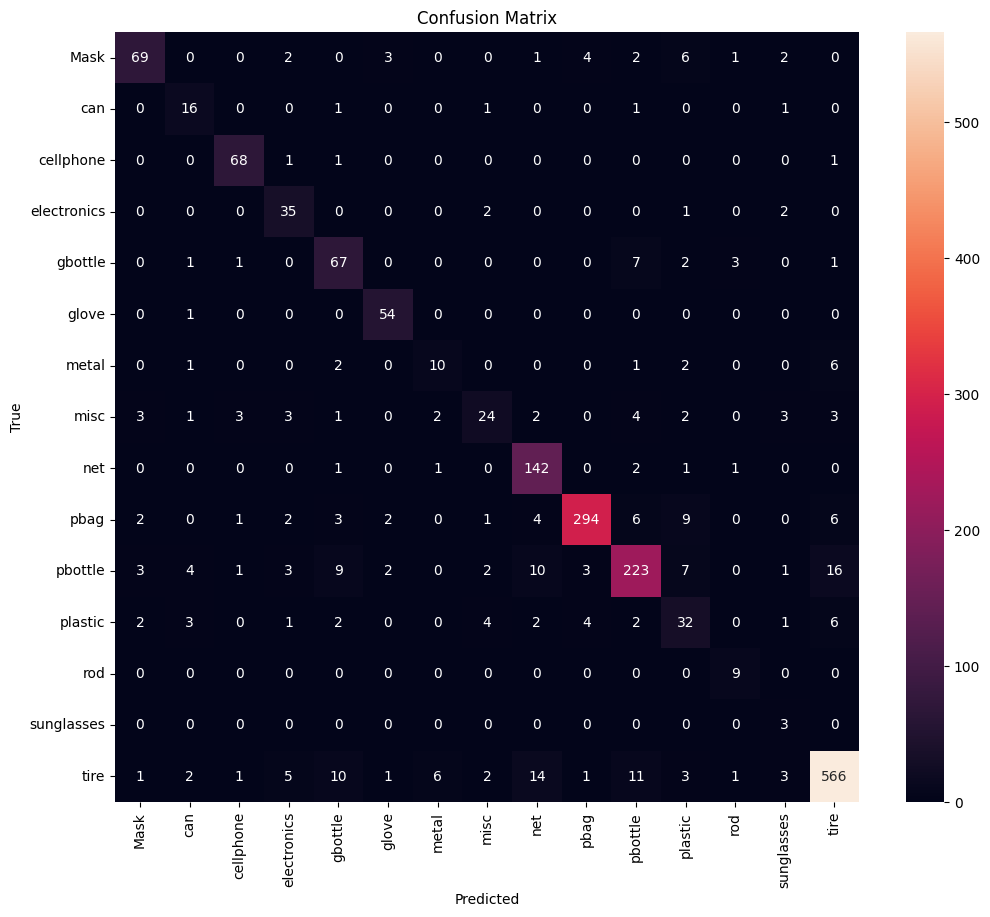

              precision    recall  f1-score   support

        Mask     0.8625    0.7667    0.8118        90
         can     0.5517    0.8000    0.6531        20
   cellphone     0.9067    0.9577    0.9315        71
 electronics     0.6731    0.8750    0.7609        40
     gbottle     0.6907    0.8171    0.7486        82
       glove     0.8710    0.9818    0.9231        55
       metal     0.5263    0.4545    0.4878        22
        misc     0.6667    0.4706    0.5517        51
         net     0.8114    0.9595    0.8793       148
        pbag     0.9608    0.8909    0.9245       330
     pbottle     0.8610    0.7852    0.8214       284
     plastic     0.4923    0.5424    0.5161        59
         rod     0.6000    1.0000    0.7500         9
  sunglasses     0.1875    1.0000    0.3158         3
        tire     0.9355    0.9027    0.9188       627

    accuracy                         0.8525      1891
   macro avg     0.7065    0.8136    0.7330      1891
weighted avg     0.8637   

In [ ]:
# Cell 12 — Validation evaluation
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Predict val
y_true = []
y_pred = []
y_score = []

# Explicitly iterate through the validation sequence batches by index.
for i in range(len(val_seq)):
    xb, yb = val_seq[i]
    preds = model.predict(xb, verbose=0)
    y_true.extend(np.argmax(yb, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.extend(preds)

y_true = np.array(y_true); y_pred = np.array(y_pred); y_score = np.array(y_score)

# Only proceed with metrics and plotting if predictions were actually made
# to prevent errors with empty arrays if the sequence unexpectedly yielded no data.
if len(y_true) > 0:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.savefig(os.path.join(MODELS_DIR, 'confusion_matrix.png'))
    plt.show()

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
else:
    print("Warning: No predictions were made. The validation sequence might have been empty or encountered an issue.")

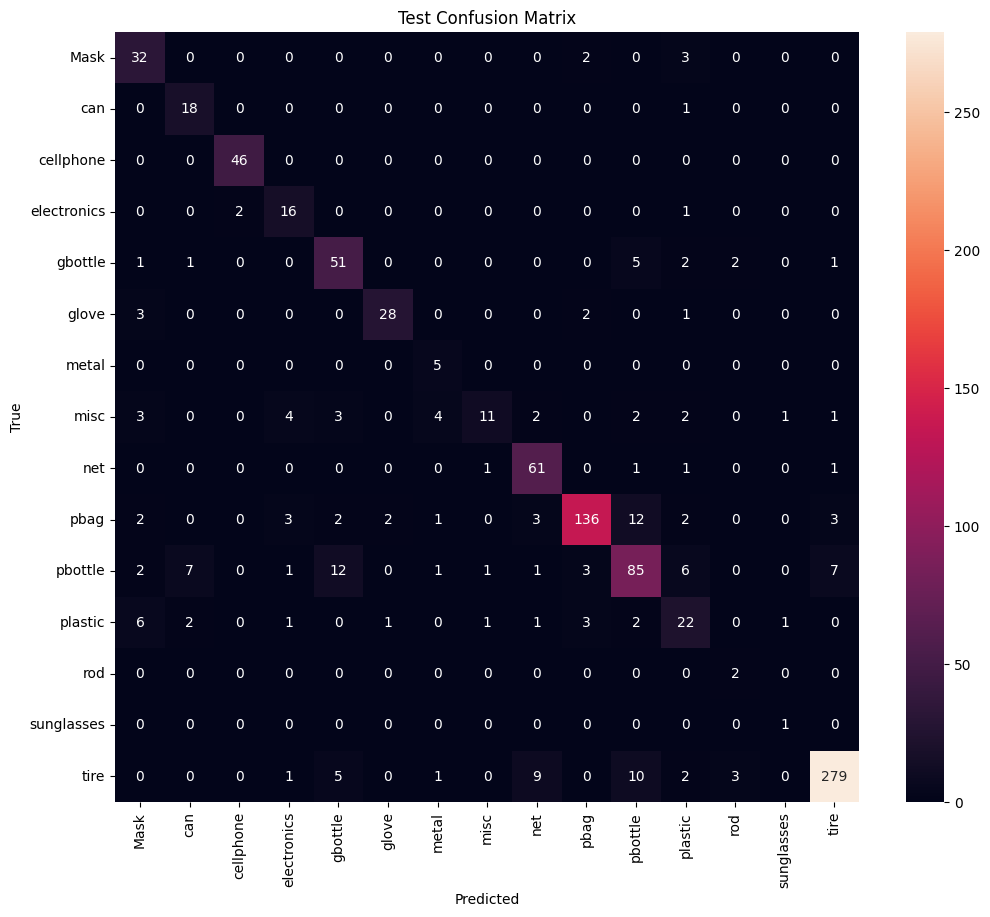


Test classification report:
              precision    recall  f1-score   support

        Mask     0.6531    0.8649    0.7442        37
         can     0.6429    0.9474    0.7660        19
   cellphone     0.9583    1.0000    0.9787        46
 electronics     0.6154    0.8421    0.7111        19
     gbottle     0.6986    0.8095    0.7500        63
       glove     0.9032    0.8235    0.8615        34
       metal     0.4167    1.0000    0.5882         5
        misc     0.7857    0.3333    0.4681        33
         net     0.7922    0.9385    0.8592        65
        pbag     0.9315    0.8193    0.8718       166
     pbottle     0.7265    0.6746    0.6996       126
     plastic     0.5116    0.5500    0.5301        40
         rod     0.2857    1.0000    0.4444         2
  sunglasses     0.3333    1.0000    0.5000         1
        tire     0.9555    0.9000    0.9269       310

    accuracy                         0.8209       966
   macro avg     0.6807    0.8335    0.7133       9

In [ ]:
# Cell 13 — Test set evaluation (final metrics for thesis)
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Predict on test set
y_true_test = []
y_pred_test = []
y_score_test = []

for i in range(len(test_seq)):
    xb, yb = test_seq[i]
    preds = model.predict(xb, verbose=0)

    y_true_test.extend(np.argmax(yb, axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))
    y_score_test.extend(preds)

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
y_score_test = np.array(y_score_test)

# --- If predictions exist, evaluate ---
if len(y_true_test) > 0:

    # Confusion Matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(12,10))
    sns.heatmap(
        cm, annot=True, fmt='d',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    cm_path = os.path.join(MODELS_DIR, 'test_confusion_matrix.png')
    plt.savefig(cm_path)
    plt.show()

    print("\nTest classification report:")
    print(classification_report(
        y_true_test,
        y_pred_test,
        target_names=CLASS_NAMES,
        digits=4
    ))

    # --- Per-class metrics ---
    precision_c, recall_c, f1_c, support_c = precision_recall_fscore_support(
        y_true_test,
        y_pred_test,
        labels=np.arange(NUM_CLASSES)
    )

    summary_df_test = pd.DataFrame({
        'class': CLASS_NAMES,
        'precision': precision_c,
        'recall': recall_c,
        'f1-score': f1_c,
        'support': support_c
    })

    summary_csv = os.path.join(MODELS_DIR, 'per_class_metrics_test_multiscale_effb4.csv')
    summary_df_test.to_csv(summary_csv, index=False)

    print('Saved test per-class metrics to:', summary_csv)

else:
    print("Warning: No predictions were made for the test set.")

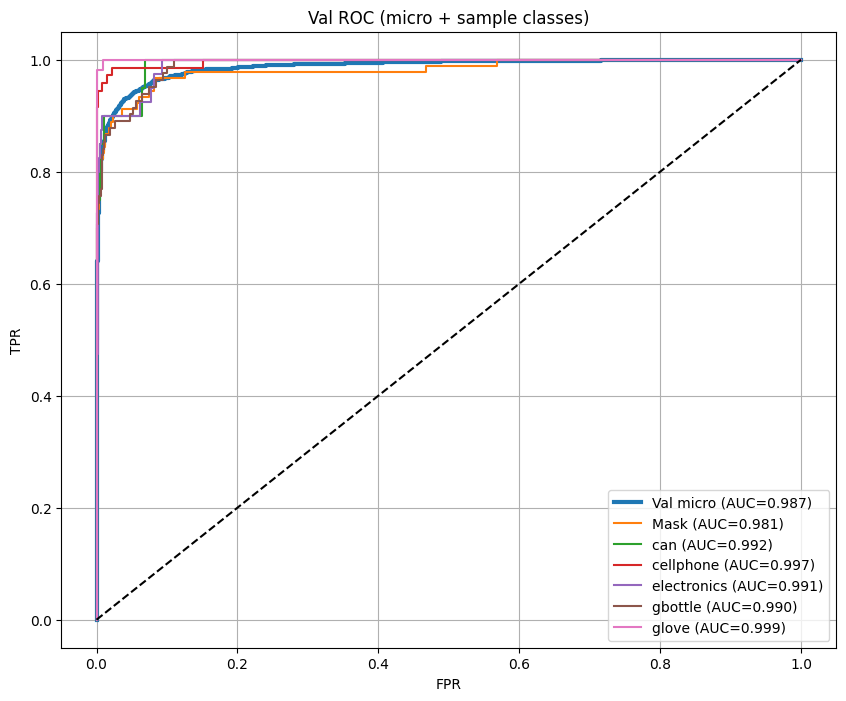

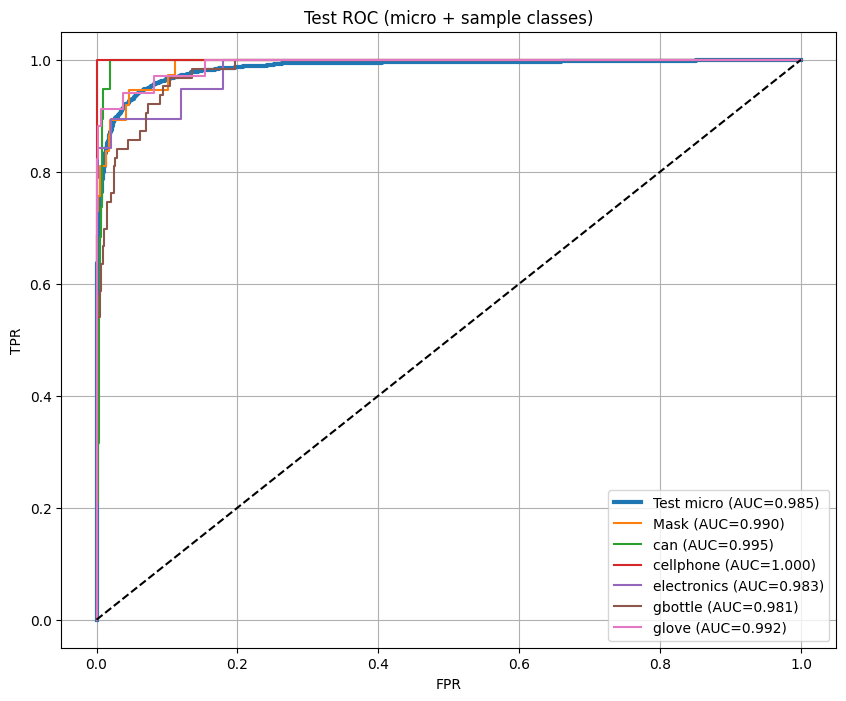

In [ ]:
# Cell 14 — ROC & PR curves (val & test)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Validation
y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
fpr = {}; tpr = {}; roc_auc = {}
precision = {}; recall = {}; pr_auc = {}
for i in range(NUM_CLASSES):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        pr_auc[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
    except:
        fpr[i], tpr[i], roc_auc[i] = [0],[0],0.0
        precision[i], recall[i], pr_auc[i] = [0],[0],0.0

fpr['micro'], tpr['micro'], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
precision['micro'], recall['micro'], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
pr_auc['micro'] = average_precision_score(y_true_bin, y_score, average='micro')

plt.figure(figsize=(10,8))
plt.plot(fpr['micro'], tpr['micro'], label=f'Val micro (AUC={roc_auc["micro"]:.3f})', linewidth=3)
for i in range(min(6, NUM_CLASSES)):
    plt.plot(fpr[i], tpr[i], label=f'{CLASS_NAMES[i]} (AUC={roc_auc[i]:.3f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Val ROC (micro + sample classes)')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(MODELS_DIR,'roc_multiscale_val.png')); plt.show()

# Test
y_true_test_bin = label_binarize(y_true_test, classes=np.arange(NUM_CLASSES))
fpr_t = {}; tpr_t = {}; roc_auc_t = {}
precision_t = {}; recall_t = {}; pr_auc_t = {}
for i in range(NUM_CLASSES):
    try:
        fpr_t[i], tpr_t[i], _ = roc_curve(y_true_test_bin[:, i], y_score_test[:, i])
        roc_auc_t[i] = auc(fpr_t[i], tpr_t[i])
        precision_t[i], recall_t[i], _ = precision_recall_curve(y_true_test_bin[:, i], y_score_test[:, i])
        pr_auc_t[i] = average_precision_score(y_true_test_bin[:, i], y_score_test[:, i])
    except:
        fpr_t[i], tpr_t[i], roc_auc_t[i] = [0],[0],0.0
        precision_t[i], recall_t[i], pr_auc_t[i] = [0],[0],0.0

fpr_t['micro'], tpr_t['micro'], _ = roc_curve(y_true_test_bin.ravel(), y_score_test.ravel())
roc_auc_t['micro'] = auc(fpr_t['micro'], tpr_t['micro'])
precision_t['micro'], recall_t['micro'], _ = precision_recall_curve(y_true_test_bin.ravel(), y_score_test.ravel())
pr_auc_t['micro'] = average_precision_score(y_true_test_bin, y_score_test, average='micro')

plt.figure(figsize=(10,8))
plt.plot(fpr_t['micro'], tpr_t['micro'], label=f'Test micro (AUC={roc_auc_t["micro"]:.3f})', linewidth=3)
for i in range(min(6, NUM_CLASSES)):
    plt.plot(fpr_t[i], tpr_t[i], label=f'{CLASS_NAMES[i]} (AUC={roc_auc_t[i]:.3f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Test ROC (micro + sample classes)')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(MODELS_DIR,'roc_multiscale_test.png')); plt.show()

In [ ]:
for layer in model.layers[-25:]:
    try:
        print(layer.name, layer.output.shape)
    except:
        print(layer.name, "No shape")


conv2d_41 (None, 28, 28, 128)
batch_normalization_30 (None, 56, 56, 128)
batch_normalization_31 (None, 14, 14, 128)
batch_normalization_32 (None, 7, 7, 128)
batch_normalization_33 (None, 7, 7, 128)
batch_normalization_34 (None, 224, 224, 128)
batch_normalization_35 (None, 112, 112, 128)
batch_normalization_36 (None, 56, 56, 128)
batch_normalization_37 (None, 28, 28, 128)
global_average_pooling2d_15 (None, 128)
global_average_pooling2d_16 (None, 128)
global_average_pooling2d_17 (None, 128)
global_average_pooling2d_18 (None, 128)
global_average_pooling2d_19 (None, 128)
global_average_pooling2d_20 (None, 128)
global_average_pooling2d_21 (None, 128)
global_average_pooling2d_22 (None, 128)
concatenate_7 (None, 1024)
dense_17 (None, 1024)
batch_normalization_38 (None, 1024)
dropout_2 (None, 1024)
dense_18 (None, 512)
batch_normalization_39 (None, 512)
dropout_3 (None, 512)
dense_19 (None, 15)


Using fusion layer: concatenate_7
Extracting fusion-layer features from validation set...
Raw feature shape: (1891, 1024)
Valid feature shape: (1891, 1024)
Running t-SNE on sampled features...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


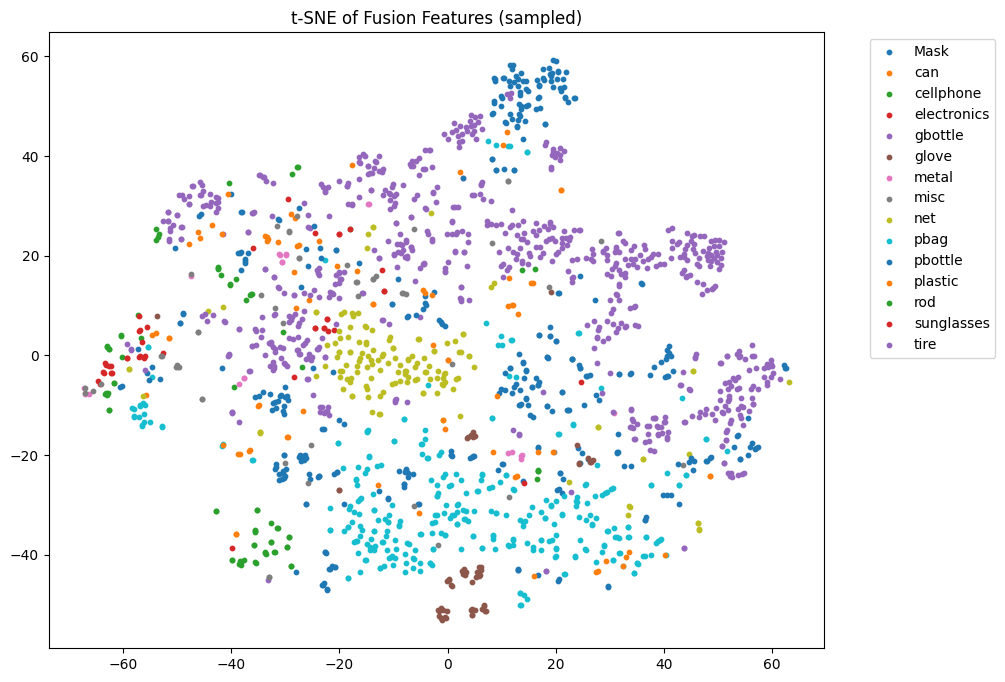

✅ t-SNE plot saved to: /content/drive/My Drive/Tahmeed Thesis/models/tsne_fusion_features.png


In [ ]:
# Cell 15 — t-SNE on fused features (from fusion vector)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
import os

# Create feature extractor
fusion_layer_name = "concatenate_7"

try:
    fusion_layer = model.get_layer(fusion_layer_name)
    print(f"Using fusion layer: {fusion_layer_name}")
except ValueError:
    raise ValueError(f"❌ Layer '{fusion_layer_name}' not found. Check your model summary.")

feat_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=fusion_layer.output
)

# Extract features
features = []
labels_ts = []

print("Extracting fusion-layer features from validation set...")

for i in range(len(val_seq)):
    xb, yb = val_seq[i]
    feats = feat_extractor.predict(xb, verbose=0)
    features.append(feats)
    labels_ts.extend(np.argmax(yb, axis=1))

# Validate extracted features
if len(features) == 0:
    print("❗ Warning: No features extracted. Validation generator may be empty.")
else:
    features = np.vstack(features)
    labels_ts = np.array(labels_ts)

    print("Raw feature shape:", features.shape)

    # Remove samples with NaN values
    mask_valid = ~np.isnan(features).any(axis=1)
    features = features[mask_valid]
    labels_ts = labels_ts[mask_valid]

    print("Valid feature shape:", features.shape)

    # Sampling
    n_samples_tsne = min(2000, features.shape[0])
    if n_samples_tsne < 10:
        print("❗ Not enough samples for t-SNE (need at least 10).")
    else:
        perplexity = min(30, n_samples_tsne - 1)

        idx = np.random.choice(features.shape[0], n_samples_tsne, replace=False)
        sampled_feats = features[idx]
        sampled_labels = labels_ts[idx]

        # Compute t-SNE
        print("Running t-SNE on sampled features...")

        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            n_iter=1000,
            init='pca',
            random_state=42
        )

        feats_2d = tsne.fit_transform(sampled_feats)

        # Plot
        plt.figure(figsize=(10, 8))

        for i, cname in enumerate(CLASS_NAMES):
            sel = sampled_labels == i
            if np.sum(sel) > 0:
                plt.scatter(
                    feats_2d[sel, 0],
                    feats_2d[sel, 1],
                    s=10,
                    label=cname
                )

        plt.title('t-SNE of Fusion Features (sampled)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        save_path = os.path.join(MODELS_DIR, "tsne_fusion_features.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()

        print("✅ t-SNE plot saved to:", save_path)

Last conv layer: None
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.
Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.


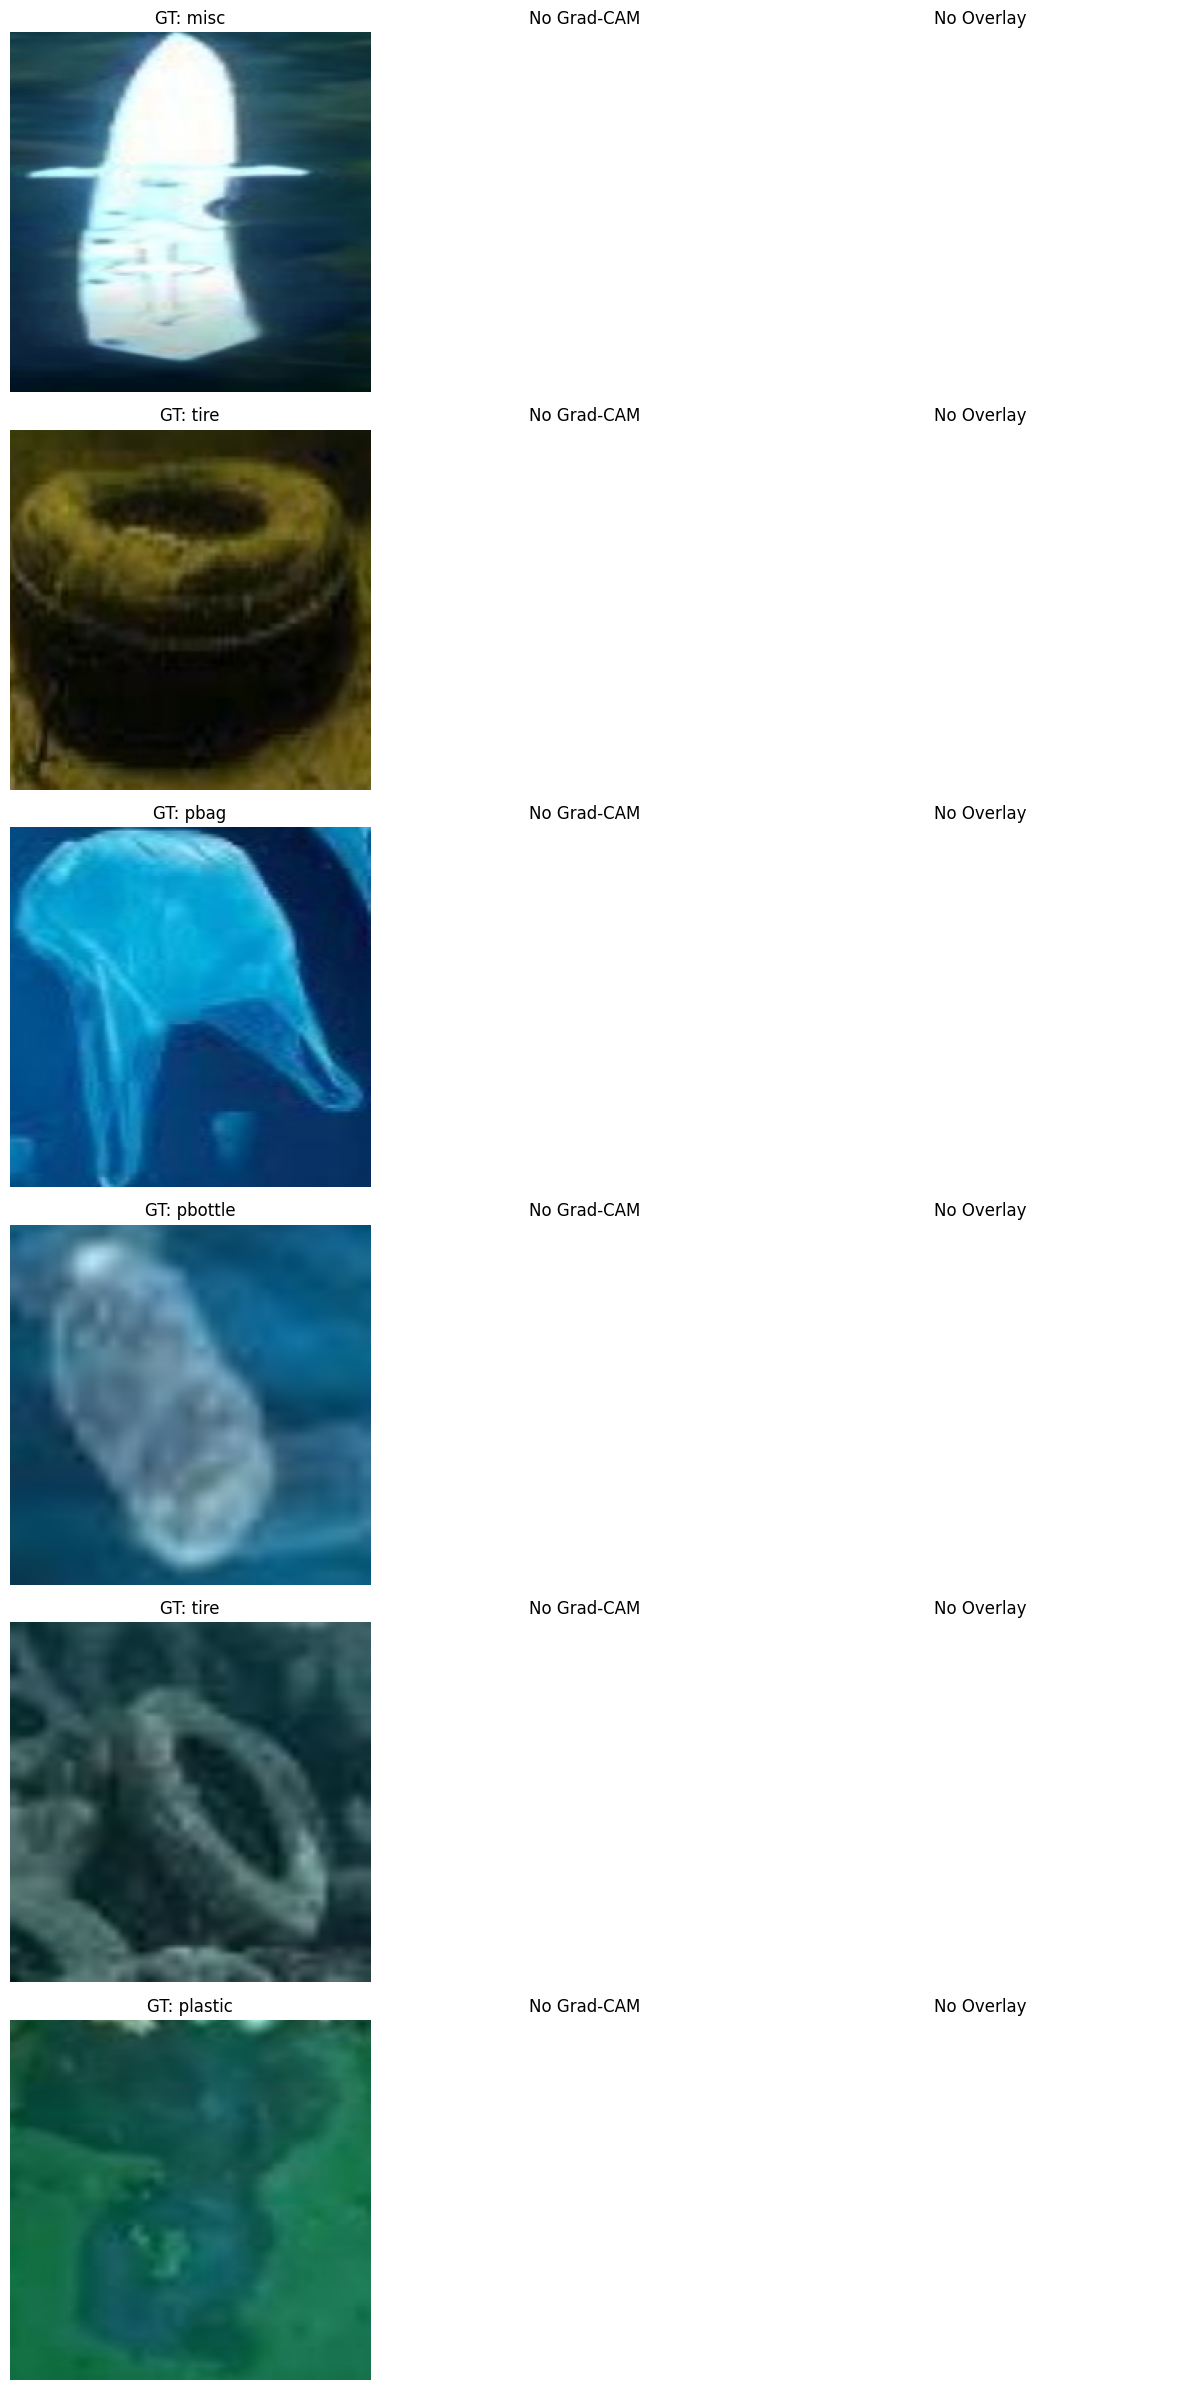

In [ ]:
# Cell 16 — Grad-CAM for sample predictions
import matplotlib.cm as cm
import tensorflow as tf

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.Model) and layer.name == 'efficientnetb0':
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                return layer.name

    # If not found or preferred, then iterate through explicit Conv2D layers in the main model structure
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                return layer.name
    return None

last_conv_name = find_last_conv_layer(model)
print('Last conv layer:', last_conv_name)

import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# sample and plot
n = 6
sample_idxs = np.random.choice(len(val_index), n, replace=False)
fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
for i, sidx in enumerate(sample_idxs):
    img_path, cls, x1,y1,x2,y2 = val_index[sidx]
    img = cv2.imread(img_path); img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crop = img_rgb[y1:y2, x1:x2]
    if crop.size == 0: # Handle empty crop case
        print(f"Warning: Empty crop for {img_path} at ({x1},{y1},{x2},{y2}). Using full image for display.")
        crop = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE)) # Use full image if crop is invalid or empty
    crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE)).astype(np.float32)
    inp = np.expand_dims(crop_resized, 0)
    preds = model.predict(inp, verbose=0)[0] # Suppress predict output
    pred_id = np.argmax(preds)

    # Ensure a last_conv_name was found before proceeding with heatmap generation
    if last_conv_name is None:
        print("Error: No suitable convolutional layer found for Grad-CAM. Cannot generate heatmap for this sample.")
        # Fallback for display, e.g., showing original image only
        axes[i,0].imshow(crop_resized.astype('uint8')); axes[i,0].axis('off'); axes[i,0].set_title(f'GT: {CLASS_NAMES[cls]}')
        axes[i,1].set_title('No Grad-CAM')
        axes[i,1].axis('off')
        axes[i,2].set_title('No Overlay')
        axes[i,2].axis('off')
        continue

    heatmap = make_gradcam_heatmap(inp, model, last_conv_name, pred_index=pred_id)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = cm.get_cmap('jet')
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = np.uint8(jet_heatmap * 255)
    superimposed_img = cv2.addWeighted(crop_resized.astype('uint8'), 0.6, jet_heatmap, 0.4, 0)

    axes[i,0].imshow(crop_resized.astype('uint8')); axes[i,0].axis('off'); axes[i,0].set_title(f'GT: {CLASS_NAMES[cls]}')
    axes[i,1].imshow(heatmap, cmap='jet'); axes[i,1].axis('off'); axes[i,1].set_title(f'Grad-CAM (pred {CLASS_NAMES[pred_id]} {preds[pred_id]:.2f})')
    axes[i,2].imshow(superimposed_img.astype('uint8')); axes[i,2].axis('off'); axes[i,2].set_title('Overlay')
plt.tight_layout(); plt.savefig(os.path.join(MODELS_DIR, 'gradcam_samples.png'))
plt.show()

In [ ]:
# Cell 17 — Save per-class metrics (val & test) and final report artifacts
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

precision_c_v, recall_c_v, f1_c_v, support_c_v = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(NUM_CLASSES))
summary_val = pd.DataFrame({
    'class': CLASS_NAMES,
    'precision': precision_c_v,
    'recall': recall_c_v,
    'f1-score': f1_c_v,
    'support': support_c_v
})
summary_val.to_csv(os.path.join(MODELS_DIR, 'per_class_metrics_val_multiscale.csv'), index=False)

precision_c_t, recall_c_t, f1_c_t, support_c_t = precision_recall_fscore_support(y_true_test, y_pred_test, labels=np.arange(NUM_CLASSES))
summary_test = pd.DataFrame({
    'class': CLASS_NAMES,
    'precision': precision_c_t,
    'recall': recall_c_t,
    'f1-score': f1_c_t,
    'support': support_c_t
})
summary_test.to_csv(os.path.join(MODELS_DIR, 'per_class_metrics_test_multiscale.csv'), index=False)

print('Saved metrics and artifacts to', MODELS_DIR)